In [12]:
import numpy as np
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [13]:
#First we must load the datasets from the CSV files included
#The data was scrapped from BasketBallReference.com
#The first dataset is the MVP player statistics and the 
#resulting vote shares due to those statistics, the stats
#are collected from 1985 to the 2018-2019 Season
mvp_stats = pd.read_csv('NewData/MVPStats.csv')
#In order to predict the mvp of the new season, we must combine
#two different data sets combining the regular per game stats
#of all players along with some advanced statistics like win shares
per_game_stats = pd.read_csv('NewData/2019PlayerStats.csv')
advanced_stats = pd.read_csv('NewData/2019AdvancedStats.csv')

In [14]:
#Next we combine the per_game_stats and the advanced stats
advanced_stats = advanced_stats.drop(columns=['Player'])
player_stats = pd.concat([per_game_stats,advanced_stats],axis=1,sort=False)
mvp_stats = mvp_stats.fillna(0)
#Use a KMeansRegressor to find the values the most highly correlate with the Share column
#which represents the amount of votes an individual received based on their statisitcs
from sklearn.feature_selection import SelectKBest, mutual_info_regression
#Define the features
features = ['PTS','TRB','AST','STL','BLK','FG%','3P%','FT%','WS','WS/48']

X = mvp_stats[features].to_numpy()
#Here the target is the award share category
Y = mvp_stats[['Share']].to_numpy()
Y = Y.reshape(Y.shape[0],)

#Define the selector, choose the top 5 k values
kselector = SelectKBest(mutual_info_regression, k = 5)
#Fit the data
top_features = kselector.fit(X,Y)

sorted_features = np.argsort(kselector.scores_)[::-1]

for i in sorted_features:
    print(f"{features[i]}: {kselector.scores_[i]:.4f}")

WS: 0.3096
WS/48: 0.2835
PTS: 0.1898
TRB: 0.0756
AST: 0.0456
FT%: 0.0409
STL: 0.0369
3P%: 0.0029
FG%: 0.0016
BLK: 0.0000


# Select K Best
By using a Kmeans selector we can find which points correlate heavily with winshare(Share). Now we will plot the parameters
on a heatmap to visually represent the correlations of all parameters with respect to each other

In [15]:
#Create a correlation matrix
matrix_data = mvp_stats[features + ['Share']]

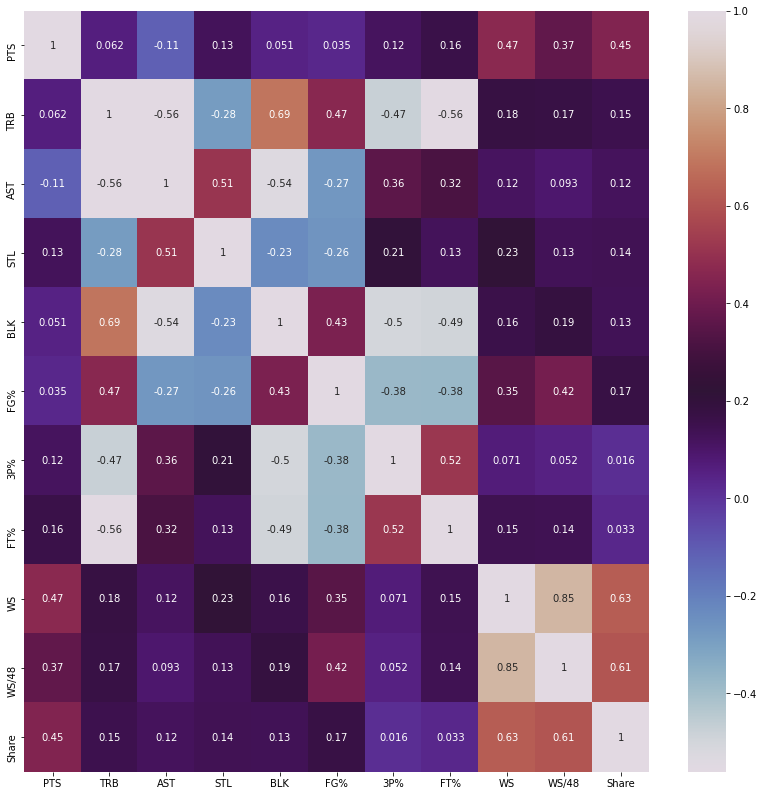

In [22]:
matrix = plt.figure(figsize= (14,14))
matrix.set_facecolor('white')
sns.heatmap(matrix_data.corr(),annot=True,cmap='twilight')

# Heatmap interpretation
As you can see, on the bottom row, we see which values are highly correlated with winshare.
What we see is that Winshare(WS), Winshare per 48 minutes(WS/48) and Points Per Game(PPG) are highly correlated
with MVP voting shares. This is beneficial because we can reduce the dimensionality of the data 
further to boost efficiency. Because winshare is so highly correlated we can make a test set based 
on the top 40 players of the 2018-2019 season to predict the MVP of that season. This also can be interpreted as 
the notion that analysts tend to look at these statistics more heavily when considering the next potential MVP

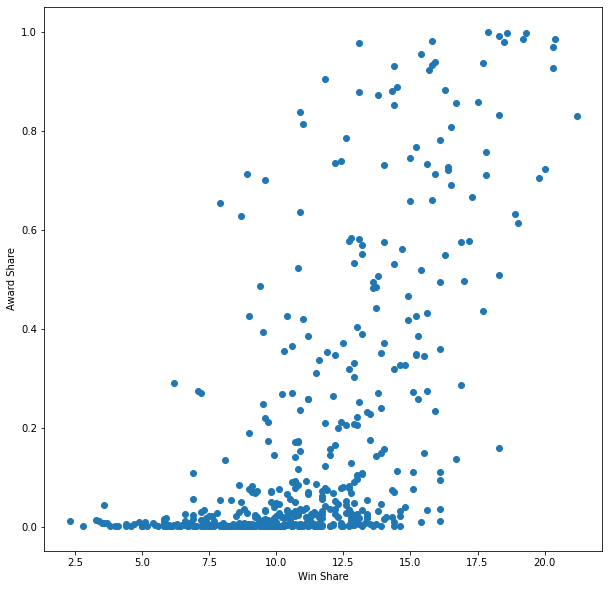

In [21]:
#Because Win Shares are the highest correlated let us look at a graph that shows the 
#win shares vs. award shares on a scatter plot
plt.figure(figsize=(10, 10))
plt.xlabel('Win Share')
plt.ylabel('Award Share')

plt.scatter(mvp_stats.WS, mvp_stats.Share)

# Scatter Plot
The graph shows that the higher the win share the higher amount of award shares. However the data is 
skewed where there are alot more individuals with lower win shares, so when training the set and validating
it can potentially lead to disproportionate data in the training and validation sets which can lead to low 
accuracy

In [24]:
#We will define the training and validation sets as 75 to 25 percent
#of the MVP stats data. 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

feats = ['PTS','TRB','AST','WS','WS/48']
X1 = mvp_stats[feats].to_numpy()
Y1 = mvp_stats[['Share']].to_numpy()
Y1 = Y1.reshape(Y1.shape[0],)

X_train,X_valid,Y_train, Y_valid = model_selection.train_test_split(X1,Y1,test_size=0.40,random_state=100)
model = Ridge(alpha =0.01)
model.fit(X_train,Y_train)
result = model.score(X_valid,Y_valid)
print("Accuracy: %.2f%%" % (result*100))

Accuracy: 40.73%


In [26]:
#We now create the test data after validating the model
#by grabbing the top 40 players from 2019 based on winshares
test_data = player_stats.nlargest(40,'WS')
X_test = test_data[feats].to_numpy()

X_test = np.nan_to_num(X_test)

Y_pred = model.predict(X_test)
ranking_indices = np.argsort(Y_pred)[::-1]
preds = Y_pred[ranking_indices]

for i in range(10):
    print(f"{i+1}. {test_data.iloc[ranking_indices[i]].Player , preds[i]}")

1. ('James Harden\\hardeja01', 0.5430978605511866)
2. ('Giannis Antetokounmpo\\antetgi01', 0.5305509950258177)
3. ('Anthony Davis\\davisan02', 0.2954994217120529)
4. ('Rudy Gobert\\goberru01', 0.2886506521905766)
5. ('Nikola JokiÄ‡\\jokicni01', 0.28283137803222835)
6. ('Paul George\\georgpa01', 0.24864435381610128)
7. ('Damian Lillard\\lillada01', 0.24780113916127455)
8. ('Kevin Durant\\duranke01', 0.23713910012792472)
9. ('Joel Embiid\\embiijo01', 0.21536457511438634)
10. ('Kawhi Leonard\\leonaka01', 0.20532973695965795)


As we can see, the rankings are shown above. The actual MVP was Giannis Antetokounmpo and James Harden was a runner up. However, in terms of the vote sharing the numbers are not so far off. Giannis earned around 35 percent of the MVP votings while Harden received around 30 percent. This can be interpreted in numerous way, we can see this as a very close MVP run, which it was, but also we can reflect on the fact that because MVP votings are based on votes, we can see that in close races like this, personal bias may play into account.